# Import libraries and data upload

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [83]:
df = pd.read_csv(r"C:\Users\USER\OneDrive\Documents\Property_prices_predictions\V3.csv")
df.head()

,Date,Year,Locality,Estimated Value,Sale Price,Property,Residential,num_rooms,num_bathrooms,carpet_area,property_tax_rate,Face
0,2009-01-02,2009,Waterbury,111440.0,185000.0,Single Family,Detached House,3,3,996.0,1.025953,South
1,2009-01-02,2009,NaN,73080.0,152000.0,Single Family,Detached House,3,1,935.0,1.025953,North
2,2009-01-02,2009,Waterbury,50540.0,105000.0,Single Family,Detached House,3,1,951.0,1.025953,East
3,2009-01-02,2009,Norwalk,571060.0,1000000.0,Single Family,Detached House,3,2,NaN,1.025953,South
4,2009-01-02,2009,Bridgeport,4775276.0,272900.0,Single Family,Detached House,3,1,971.0,1.025953,East


# Data cleaning

In [84]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df[['Date', 'Year', 'Month', 'Quarter']].head()

,Date,Year,Month,Quarter
0,2009-01-02,2009,1,1
1,2009-01-02,2009,1,1
2,2009-01-02,2009,1,1
3,2009-01-02,2009,1,1
4,2009-01-02,2009,1,1


In [85]:
# Handle Missing Values
df['Locality'] = df['Locality'].fillna('Unknown')
df['Estimated Value'] = df.groupby('Locality')['Estimated Value'].transform(lambda x: x.fillna(x.median()))
df['Estimated Value'] = df['Estimated Value'].fillna(df['Estimated Value'].median())
df['carpet_area'] = df.groupby('Property')['carpet_area'].transform(lambda x: x.fillna(x.median()))
df['carpet_area'] = df['carpet_area'].fillna(df['carpet_area'].median())

Missing values were addressed using a combination of categorical imputation and group-based median imputation to preserve data integrity.
- For the Locality column, missing entries were replaced with the label "Unknown" to retain those records for analysis.
- For Estimated Value, missing data was imputed using the median value within each Locality, ensuring that price estimates reflected regional market differences. Any remaining nulls, under "Unknown" Locality, were filled using the overall median.
- Similarly, missing Carpet Area values were filled using the median per Property type, allowing the imputation to respect differences in property characteristics.

In [86]:
# outlier detection using IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"{column}: {len(outliers)}")
    return outliers

for col in ['Sale Price', 'Estimated Value', 'carpet_area']:
    detect_outliers_iqr(df, col)

Sale Price: 1011
Estimated Value: 1114
carpet_area: 1559


In [87]:
# Cap outliers
for col in ['Sale Price', 'Estimated Value', 'carpet_area']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])

Outliers were handled using the Interquartile Range (IQR) method to minimize the influence of extreme values while preserving the overall data structure. For each numeric feature — Sale Price, Estimated Value, and carpet_area — the first (Q1) and third (Q3) quartiles were computed, and the interquartile range (IQR = Q3 − Q1) was used to define acceptable data limits. Any values falling below (Q1 − 1.5 × IQR) were capped at the lower bound, while those above (Q3 + 1.5 × IQR) were capped at the upper bound. This approach ensures that the dataset remains realistic and free from distortions caused by extreme outliers, improving the reliability of subsequent analysis and model performance.

# Feature engineering

In [88]:
# FEATURE ENGINEERING
# Ratio Features
df['rooms_per_bathroom'] = df['num_rooms'] / df['num_bathrooms']
df['price_per_sqft'] = df['Sale Price'] / df['carpet_area']
df['price_to_estimated_ratio'] = df['Sale Price'] / df['Estimated Value']

# Interaction Features
df['value_area_interaction'] = df['Estimated Value'] * df['carpet_area']
df['rooms_area_interaction'] = df['num_rooms'] * df['carpet_area']
df['area_per_room'] = df['carpet_area'] / df['num_rooms']

# Temporal Feature
df['is_recent_sale'] = (df['Year'] >= 2020).astype(int)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [89]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
# ENCODING CATEGORICAL VARIABLES
# Ordinal Encoding for 'Residential'
residential_order = {
    'Detached House': 1,
    'Duplex': 2,
    'Triplex': 3,
    'Fourplex': 4
}
df['Residential'] = df['Residential'].map(residential_order)

# One-Hot Encoding for nominal categorical features
one_hot_cols = ['Locality', 'Property', 'Face']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)
dummy_cols = df.filter(regex='^(Locality|Property|Face)_').columns
df[dummy_cols] = df[dummy_cols].astype(int)
df.head()

,Date,Year,Estimated Value,Sale Price,Residential,num_rooms,num_bathrooms,carpet_area,property_tax_rate,Month,...,Locality_Unknown,Locality_Waterbury,Locality_West Hartford,Property_Four Family,Property_Single Family,Property_Three Family,Property_Two Family,Face_North,Face_South,Face_West
0,2009-01-02,2009,111440.00,185000.0,1,3,3,996.0,1.025953,1,...,0,1,0,0,1,0,0,0,1,0
1,2009-01-02,2009,73080.00,152000.0,1,3,1,935.0,1.025953,1,...,1,0,0,0,1,0,0,1,0,0
2,2009-01-02,2009,50540.00,105000.0,1,3,1,951.0,1.025953,1,...,0,1,0,0,1,0,0,0,0,0
3,2009-01-02,2009,571060.00,1000000.0,1,3,2,999.0,1.025953,1,...,0,0,0,0,1,0,0,0,1,0
4,2009-01-02,2009,841231.25,272900.0,1,3,1,971.0,1.025953,1,...,0,0,0,0,1,0,0,0,0,0


Top 10 features most correlated with Sale Price:

Sale Price                  1.000000
price_per_sqft              0.994870
Estimated Value             0.911997
value_area_interaction      0.902422
Locality_Greenwich          0.577692
price_to_estimated_ratio    0.214211
area_per_room               0.205585
Locality_Fairfield          0.181517
Property_Single Family      0.174944
Locality_Stamford           0.127890
Name: Sale Price, dtype: float64

Features least correlated with Sale Price:

Property_Four Family     -0.051745
Locality_West Hartford   -0.108774
Property_Three Family    -0.158795
Property_Two Family      -0.166011
num_bathrooms            -0.172393
carpet_area              -0.230039
num_rooms                -0.236590
rooms_area_interaction   -0.247333
Residential              -0.257203
Locality_Waterbury       -0.379316
Name: Sale Price, dtype: float64


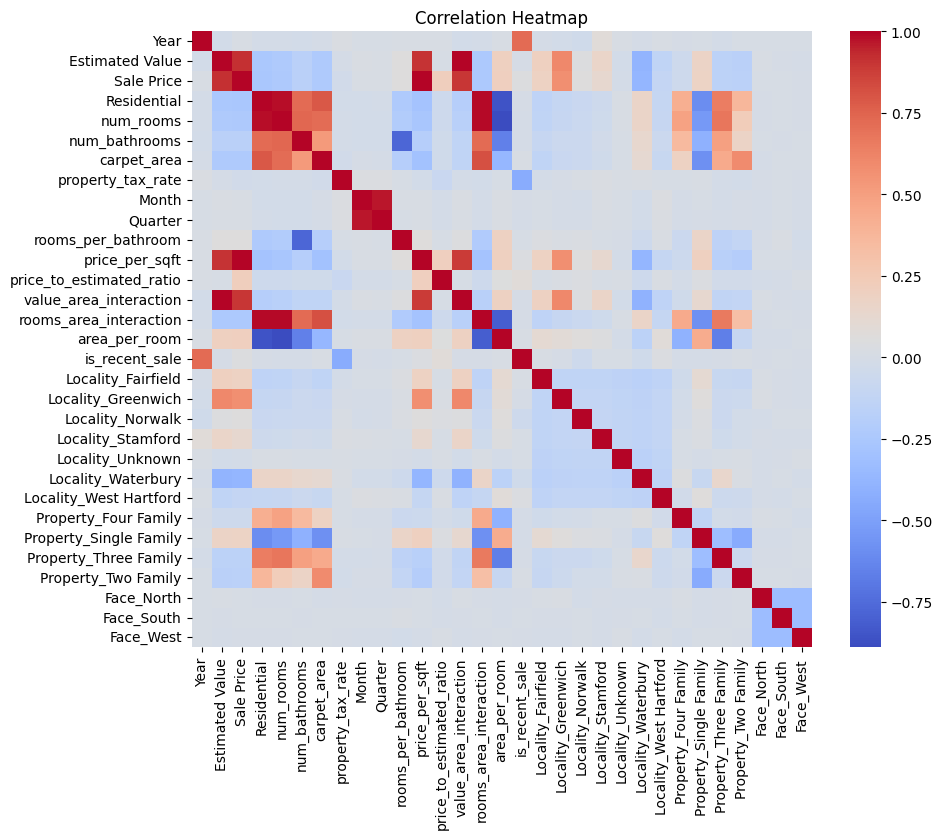

In [90]:
# correlation
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()
target_corr = corr_matrix['Sale Price'].sort_values(ascending=False)

print("Top 10 features most correlated with Sale Price:\n")
print(target_corr.head(10))
print("\nFeatures least correlated with Sale Price:\n")
print(target_corr.tail(10))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()

In [91]:
# feature selection
redundant_cols = [
    'Date',
    'carpet_area', 
    'Estimated Value', 
    'num_rooms', 
    'num_bathrooms', 
    'property_tax_rate'
]
df.drop(columns=redundant_cols, inplace=True, errors='ignore')

In [92]:
# final structure
print(df.info())
print(df.isnull().sum().sum(), "missing values remain")

df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 9996 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      9996 non-null   int32  
 1   Sale Price                9996 non-null   float64
 2   Residential               9996 non-null   int64  
 3   Month                     9996 non-null   int32  
 4   Quarter                   9996 non-null   int32  
 5   rooms_per_bathroom        9996 non-null   float64
 6   price_per_sqft            9996 non-null   float64
 7   price_to_estimated_ratio  9996 non-null   float64
 8   value_area_interaction    9996 non-null   float64
 9   rooms_area_interaction    9996 non-null   float64
 10  area_per_room             9996 non-null   float64
 11  is_recent_sale            9996 non-null   int64  
 12  Locality_Fairfield        9996 non-null   int64  
 13  Locality_Greenwich        9996 non-null   int64  
 14  Locality_Norw

,Year,Sale Price,Residential,Month,Quarter,rooms_per_bathroom,price_per_sqft,price_to_estimated_ratio,value_area_interaction,rooms_area_interaction,...,Locality_Unknown,Locality_Waterbury,Locality_West Hartford,Property_Four Family,Property_Single Family,Property_Three Family,Property_Two Family,Face_North,Face_South,Face_West
0,2009,185000.0,1,1,1,1.0,185.742972,1.660086,1.109942e+08,2988.0,...,0,1,0,0,1,0,0,0,1,0
1,2009,152000.0,1,1,1,3.0,162.566845,2.079912,6.832980e+07,2805.0,...,1,0,0,0,1,0,0,1,0,0
2,2009,105000.0,1,1,1,3.0,110.410095,2.077562,4.806354e+07,2853.0,...,0,1,0,0,1,0,0,0,0,0
3,2009,1000000.0,1,1,1,1.5,1001.001001,1.751129,5.704889e+08,2997.0,...,0,0,0,0,1,0,0,0,1,0
4,2009,272900.0,1,1,1,3.0,281.050463,0.324405,8.168355e+08,2913.0,...,0,0,0,0,1,0,0,0,0,0


In [93]:
# cleaned dataset
df.to_csv('cleaned_real_estate_data.csv', index=False)